In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/dataset_faketweets')
from helper import *
import numpy as np
import pandas as pd
import keras 
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.layers import Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers.merge import concatenate


# Reading Data 

In [ ]:
df = pd.read_csv('train_processed.csv',index_col='id')
df.pop("Unnamed: 0")
df['text']= df['text'].apply(lambda x : str(x).lower())
df.head()

,text,char_count,punctuation_count,word_count,unique_word_count,stop_word_count,mean_word_length,target
id,,,,,,,,
1,our deeds are the reason of this earthquake ma...,69,1,13,13,6,4.307692,1
4,forest fire near la ronge sask canada,38,1,7,7,0,4.428571,1
5,all residents asked to shelter in place are be...,133,3,22,18,11,4.954545,1
6,people receive wildfires evacuation orders in...,65,2,7,7,1,7.142857,1
7,just got sent this photo from ruby alaska as s...,88,2,16,15,7,4.375000,1


# Preparing Data 

In [ ]:
sequence_length = 32

Tokens = Tokenization(df['text'].copy(),pad_length=sequence_length)
vocab = Tokens.vocab 
vocab_length = len(vocab)

padded_sentences = Tokens.convert_to_numbers(df['text'].copy())

X_train, X_test, df_train, df_test = train_test_split(
    padded_sentences, 
    df, 
    test_size=0.25,
    random_state =10
)

y_train = df_train["target"]
y_test = df_test["target"]

In [ ]:
print(X_train[0])

[ 172 9401 9398 8998 4969 9156   28   24 4240  287 9399 1399    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


# gLove Embeddings

In [ ]:
file = open('glove.6B.100d.txt')
glove_dictionary = {}

for lines in file:
  entry = lines.split()
  word = entry[0]
  vector = np.asarray(entry[1:],'float32')
  glove_dictionary[word] = vector


In [ ]:
glove_dimensions = 100
glove_matrix = np.zeros((vocab_length,glove_dimensions))

for word,index in vocab.items():
  if word in glove_dictionary:
    glove_matrix[index] = glove_dictionary[word]

# Model

In [ ]:
lstm_output_dim = 8

def api():

  text_input = Input(shape=(sequence_length,))
  char_count = Input(shape=(1,))
  punctuation_count = Input(shape=(1,))
  word_count = Input(shape=(1,))
  unique_word_count = Input(shape=(1,))
  stop_word_count = Input(shape=(1,))
  mean_word_length = Input(shape=(1,))


  embed      = Embedding(input_dim=glove_matrix.shape[0], 
                        output_dim=glove_matrix.shape[1], 
                        weights = [glove_matrix], 
                        input_length=sequence_length)(text_input)
  lstm_layer =(LSTM(lstm_output_dim, return_sequences = True, recurrent_dropout=0.2))(embed)
  pool_1 = GlobalMaxPool1D()(lstm_layer)
  batchnorm_1 = BatchNormalization()(pool_1)
  
  dense_text = Dense(lstm_output_dim*2, activation = "relu")(batchnorm_1)
  dense_1_1 = Dense(1, activation= "relu")(char_count)
  dense_1_2 = Dense(1, activation= "relu")(punctuation_count)
  dense_1_3 = Dense(1, activation= "relu")(word_count)
  dense_1_4 = Dense(1, activation= "relu")(unique_word_count)
  dense_1_5 = Dense(1, activation= "relu")(stop_word_count)
  dense_1_6 = Dense(1, activation= "relu")(mean_word_length)
  dense_metadata = concatenate([dense_1_1,dense_1_2,dense_1_3,dense_1_4,dense_1_5,dense_1_6])

  merge     = concatenate([dense_text,dense_metadata])
  
  dropout_1 = Dropout(0.5)(merge)
  output = Dense(1,activation='sigmoid')(dropout_1)
 
  model  = Model(inputs=[text_input,char_count,punctuation_count,word_count,unique_word_count,stop_word_count,mean_word_length],outputs=output)
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model



In [ ]:
model = api()
model.summary()

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_204 (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 32, 100)      1645900     input_204[0][0]                  
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 32, 8)        3488        embedding_29[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_29 (Global (None, 8)            0           lstm_29[0][0]                    
______________________________________________________________________________________

In [ ]:
model = api()
X = [X_train,df_train["char_count"],df_train["punctuation_count"],df_train["word_count"],df_train["unique_word_count"],df_train["stop_word_count"],df_train["mean_word_length"]]

history = model.fit(X,y_train, validation_split=0.2, epochs=10,batch_size=64)

Epoch 1/10
72/72 [==============================] - 8s 112ms/step - loss: 1.3652 - accuracy: 0.5706 - val_loss: 0.6911 - val_accuracy: 0.6217
Epoch 2/10
72/72 [==============================] - 8s 108ms/step - loss: 0.8293 - accuracy: 0.6624 - val_loss: 0.5471 - val_accuracy: 0.7391
Epoch 3/10
72/72 [==============================] - 8s 108ms/step - loss: 0.5875 - accuracy: 0.7421 - val_loss: 0.4885 - val_accuracy: 0.7916
Epoch 4/10
72/72 [==============================] - 8s 107ms/step - loss: 0.4941 - accuracy: 0.7918 - val_loss: 0.4475 - val_accuracy: 0.8179
Epoch 5/10
72/72 [==============================] - 8s 107ms/step - loss: 0.4225 - accuracy: 0.8202 - val_loss: 0.4281 - val_accuracy: 0.8292
Epoch 6/10
72/72 [==============================] - 8s 108ms/step - loss: 0.3854 - accuracy: 0.8478 - val_loss: 0.4613 - val_accuracy: 0.7872
Epoch 7/10
72/72 [==============================] - 8s 108ms/step - loss: 0.3551 - accuracy: 0.8603 - val_loss: 0.4230 - val_accuracy: 0.8292
Epoch 

#Model Evaluation

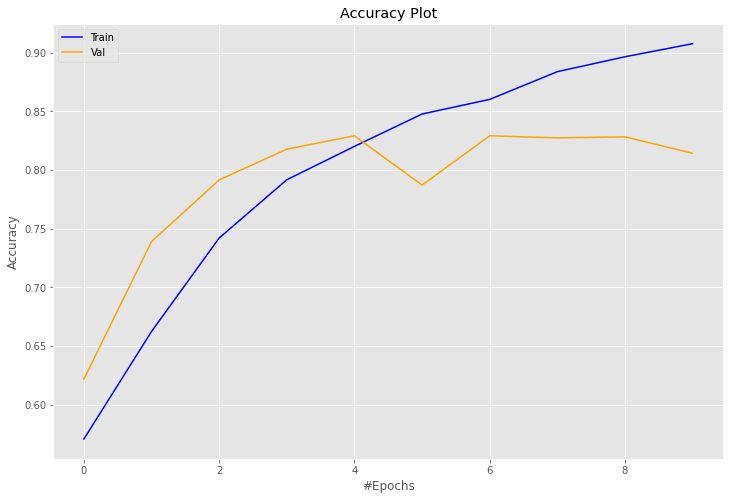

In [ ]:

def model_evaluation(model):

  t_loss = model.history['loss']
  t_acc  = model.history['accuracy']
  v_loss = model.history['val_loss']
  v_acc  = model.history['val_accuracy']
  x_axis = len(t_loss)

  fig,(ax1) = plt.subplots(1,1,figsize=(12,8))
  # ax.plot(t_loss,color = 'blue',label = 'Train')
  # ax.plot(v_loss,color = 'orange',label = 'Val')
  # ax.set_xlabel("#Epochs")
  # ax.set_ylabel("Loss")
  # ax.set_title('Loss Plot')
  # ax.legend()

  ax1.plot(t_acc,color = 'blue',label = 'Train')
  ax1.plot(v_acc,color = 'orange',label = 'Val')
  ax1.set_title('Accuracy Plot')
  ax1.set_xlabel("#Epochs")
  ax1.set_ylabel("Accuracy")
  ax1.legend()
  
  plt.show()

model_evaluation(history)

In [ ]:

X1 = [X_test,df_test["char_count"],df_test["punctuation_count"],df_test["word_count"],df_test["unique_word_count"],df_test["stop_word_count"],df_test["mean_word_length"]]

y_score = model.predict(X1)
y_pred = []
for x in y_score:
  if x > 0.5:
    y_pred.append([1])
  else:
    y_pred.append([0])

y_pred = []
for x in y_score:
  if x > 0.4:
    y_pred.append([1])
  else:
    y_pred.append([0])

print(y_pred)


metric = Metrics(y_test,y_pred,y_score)
metric.cost_matrix()


,Positive,Negative
Positive,736,121
Negative,268,875


F1-score:  0.7909725953788287
Precision:  0.7330677290836654
Recall:  0.8588098016336057
Acuracy:  0.8055
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1143
           1       0.73      0.86      0.79       857

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.80      2000
weighted avg       0.82      0.81      0.81      2000

--------------------------------------------------


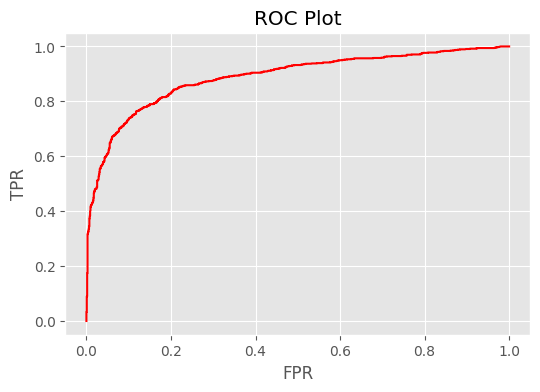

In [ ]:
metric.scores()
metric.roc_curve()
